In [2]:
from torch_snippets import *
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg19
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
from albumentations.augmentations.crops import functional as albF
import albumentations as A
import torch.nn.functional as F
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


device(type='cuda')

In [3]:
from src import Generator, Discriminator, FeatureExtractor
from src import SRDataset
from src import plot_examples
from src import CropAndCombine, InterpolateAndConcatenate

In [4]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)

generator.load_state_dict(torch.load('generator_430epoch.pth'))

c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.



<All keys matched successfully>

In [5]:
lr_path = '../DIV2K_train_LR_bicubic/X4/'
hr_path = '../DIV2K_train_HR/'
dataset = SRDataset(lr_path, hr_path, crop_size=24, augment=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

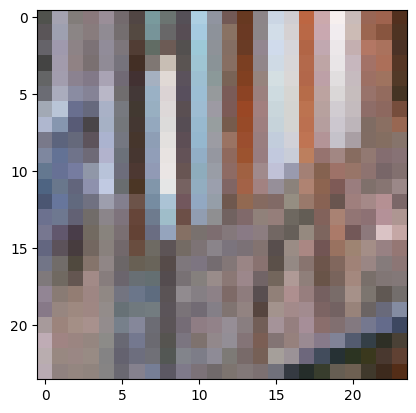

In [10]:
sample = next(iter(dataloader))
lr, hr = sample
plt.imshow(lr[0].permute(1, 2, 0))

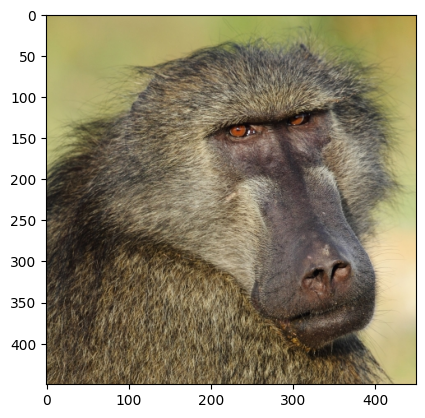

In [19]:
test_image = Image.open('../DIV2K_train_LR_bicubic/X4/0061x4.png')
test_image = np.array(test_image)

test_image = Image.open('monkey.jpg')
test_image = np.array(test_image)
plt.imshow(test_image)

In [20]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [21]:
crops = CropAndCombine(test_image, (96, 96))
pieces = crops.get_image_pieces()
generated_pieces = []
for i in range(len(pieces)):
    piece  = transform(Image.fromarray(pieces[i]).convert('RGB')).unsqueeze(0).to(device)
    prediction = generator(piece)
    prediction = prediction.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    generated_pieces.append((prediction *255).clip(0, 255).astype(np.uint8))
    # generated_pieces.append(prediction)

In [22]:
combined_image = crops.combine_pieces(generated_pieces, crops.padded_image.shape[:2], crop_size=crops.crop_size, upsample_factor=4, delete_padded=True)

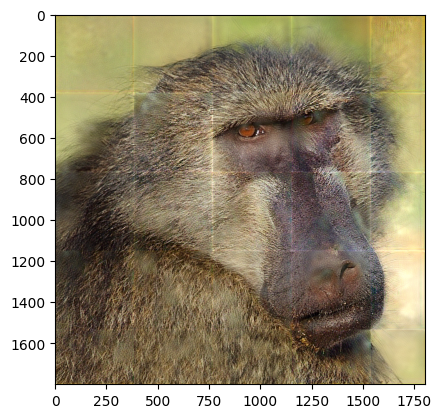

In [23]:
plt.imshow(combined_image)

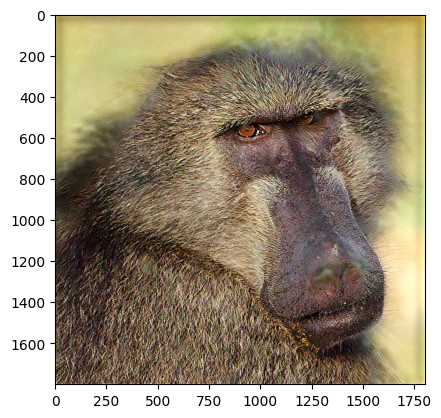

In [24]:
generator.load_state_dict(torch.load('generator_430epoch.pth'))
pre = transform(Image.fromarray(test_image).convert('RGB')).unsqueeze(0).to(device)
prediction = generator(pre)
prediction = prediction.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(prediction)
save_image(transform(prediction).unsqueeze(0), 'test4.png')

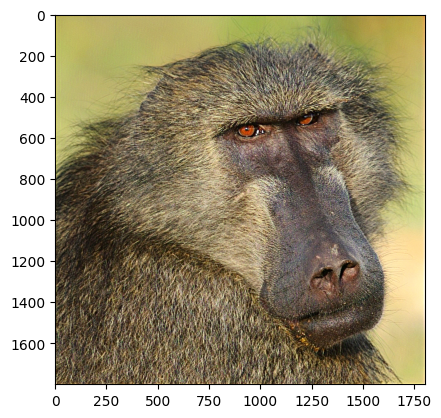

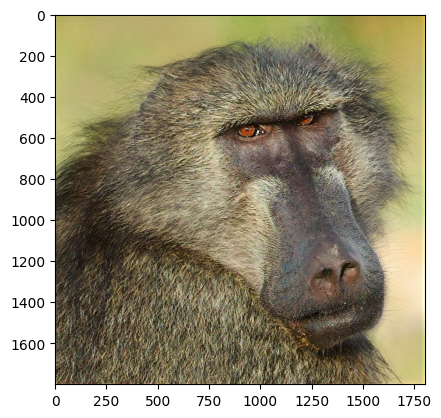

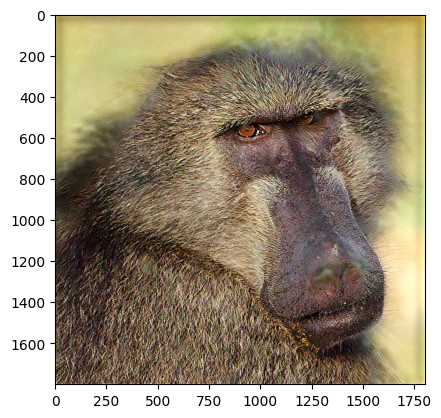

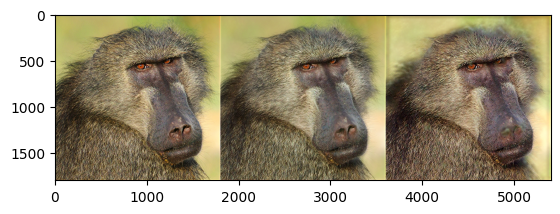

In [25]:
## test 3 version of the generator
generator = Generator().to(device)
model_names = ['generator_200epoch.pth', 'generator_300epoch.pth', 'generator_430epoch.pth']
combined_images = []
for i in model_names:
    generator.load_state_dict(torch.load(i))
    image  = transform(Image.fromarray(test_image).convert('RGB')).unsqueeze(0).to(device)
    prediction = generator(image)
    prediction = prediction.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

    combined_images.append(prediction)

    plt.imshow(prediction)
    plt.show()

concated_image = np.concatenate(combined_images, axis=1)
save_image(transform(concated_image).unsqueeze(0), 'concated_image.png')
plt.imshow(concated_image)
plt.show()

In [33]:
save_image(transform(combined_image).unsqueeze(0), 'test3.png')

### Training

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)

# # Load the saved state dictionaries
generator.load_state_dict(torch.load('generator_400epoch.pth'))
discriminator.load_state_dict(torch.load('discriminator_400epoch.pth'))

optimizer_G = optim.AdamW(generator.parameters(), lr=1e-5, betas=(0.9, 0.999))
optimizer_D = optim.AdamW(discriminator.parameters(), lr=1e-5, betas=(0.9, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss().to(device)
content_loss = nn.MSELoss().to(device)

c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yousef\anaconda3\envs\YOLO\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


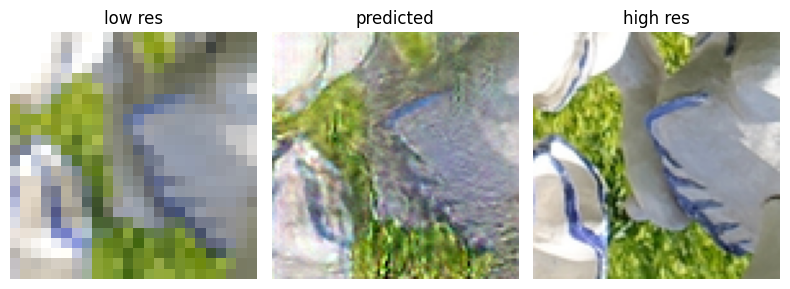

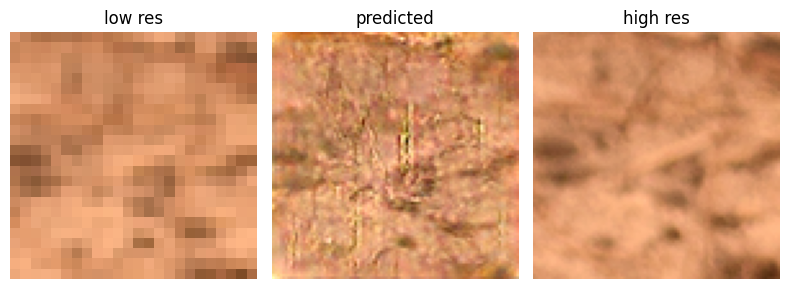

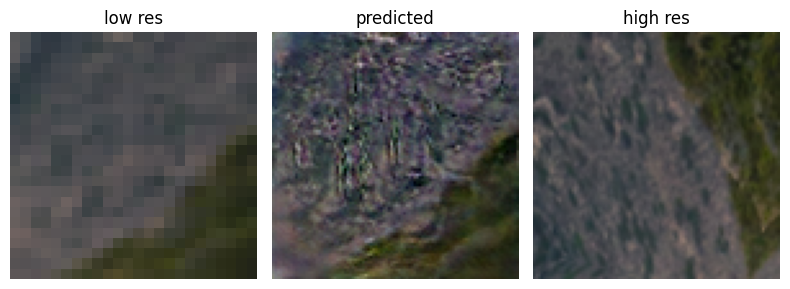

EPOCH: 0.980  Loss_G: 0.029  Loss_D: 0.037  (84.80s - 2511.00s remaining)

EPOCH: 1.000  Loss_D: 0.265  Loss_G: 0.031  (86.46s - 2507.42s remaining)


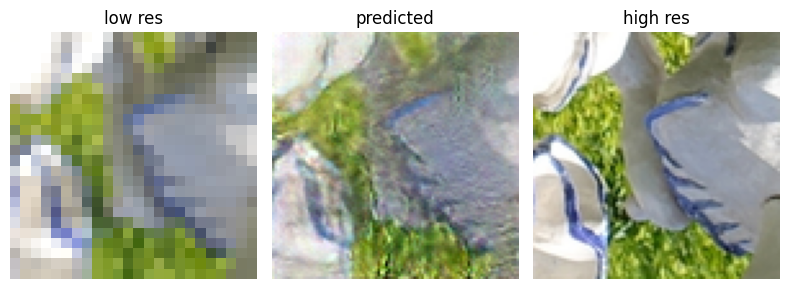

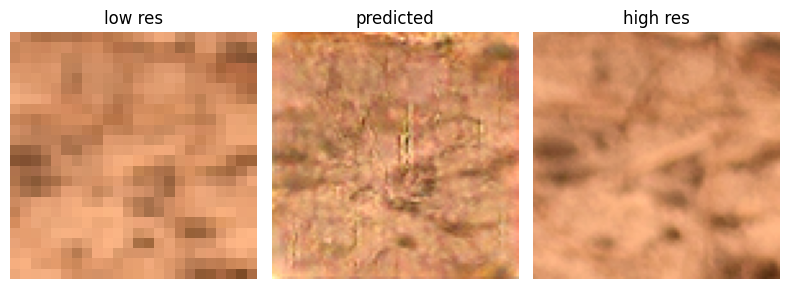

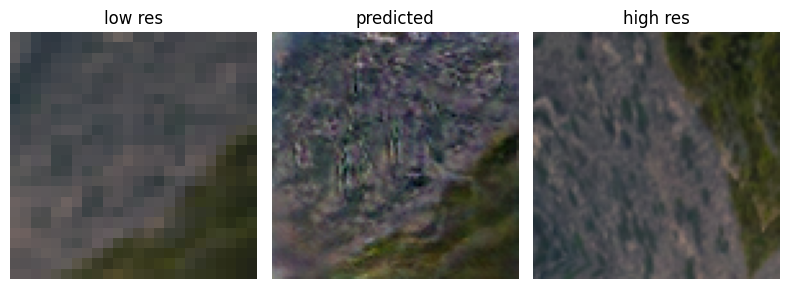

EPOCH: 2.000  Loss_D: 0.169  Loss_G: 0.029  (174.41s - 2441.77s remaining)
EPOCH: 3.000  Loss_D: 0.324  Loss_G: 0.029  (260.82s - 2347.41s remaining)
EPOCH: 4.000  Loss_D: 0.442  Loss_G: 0.029  (346.45s - 2251.90s remaining)
EPOCH: 5.000  Loss_D: 0.354  Loss_G: 0.030  (434.53s - 2172.63s remaining)
EPOCH: 5.980  Loss_G: 0.030  Loss_D: 0.462  (518.32s - 2081.96s remaining)

EPOCH: 6.000  Loss_D: 0.307  Loss_G: 0.030  (519.91s - 2079.64s remaining)


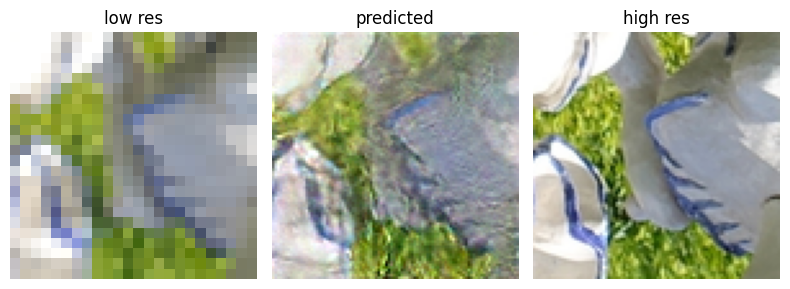

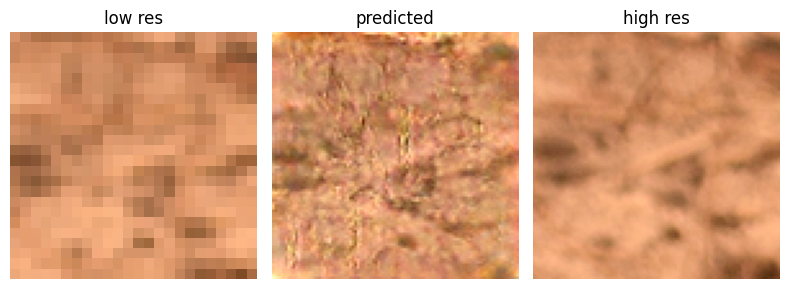

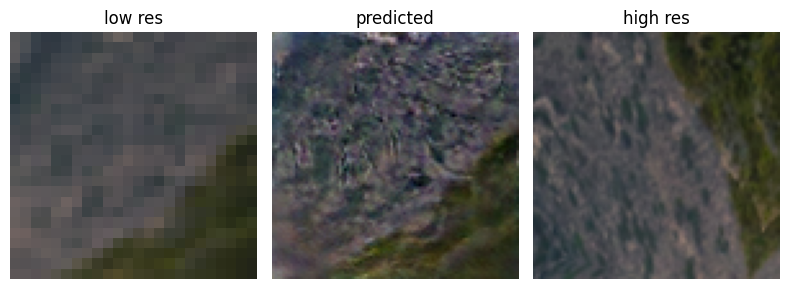

EPOCH: 7.000  Loss_D: 0.385  Loss_G: 0.029  (609.60s - 2002.98s remaining)
EPOCH: 8.000  Loss_D: 0.223  Loss_G: 0.030  (696.52s - 1915.44s remaining)
EPOCH: 9.000  Loss_D: 0.323  Loss_G: 0.031  (781.39s - 1823.23s remaining)
EPOCH: 10.000  Loss_D: 0.358  Loss_G: 0.031  (863.77s - 1727.54s remaining)
EPOCH: 10.980  Loss_G: 0.025  Loss_D: 0.091  (944.46s - 1636.03s remaining)

EPOCH: 11.000  Loss_D: 0.229  Loss_G: 0.030  (946.14s - 1634.25s remaining)


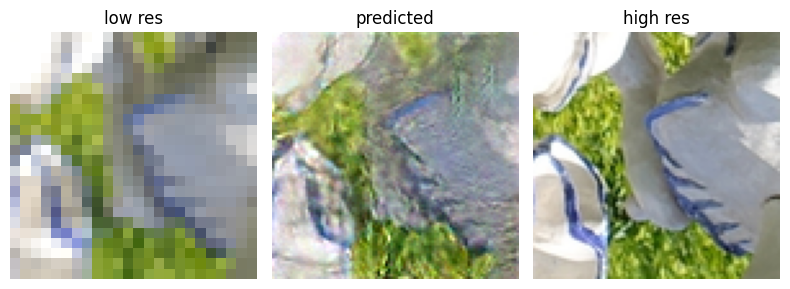

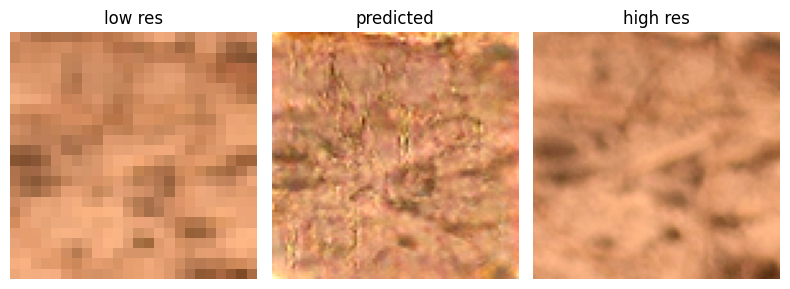

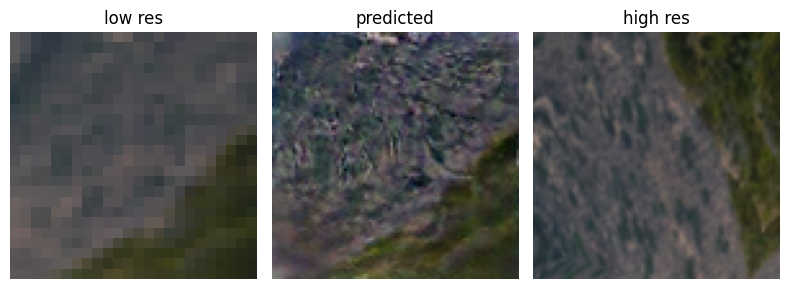

EPOCH: 12.000  Loss_D: 0.291  Loss_G: 0.029  (1030.58s - 1545.87s remaining)
EPOCH: 13.000  Loss_D: 0.363  Loss_G: 0.030  (1111.89s - 1454.01s remaining)
EPOCH: 14.000  Loss_D: 0.309  Loss_G: 0.030  (1194.80s - 1365.48s remaining)
EPOCH: 15.000  Loss_D: 0.324  Loss_G: 0.030  (1276.41s - 1276.41s remaining)
EPOCH: 15.980  Loss_G: 0.025  Loss_D: 0.190  (1356.27s - 1189.92s remaining)

EPOCH: 16.000  Loss_D: 0.332  Loss_G: 0.029  (1357.86s - 1188.13s remaining)


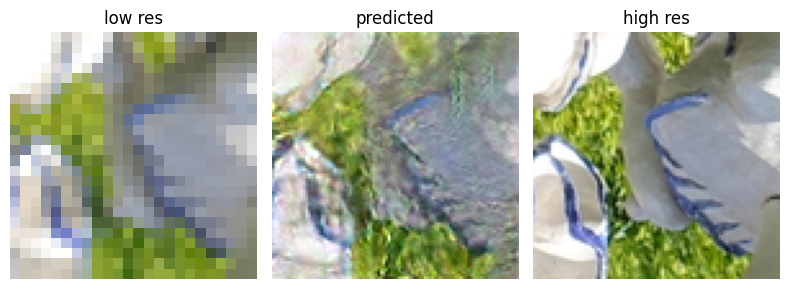

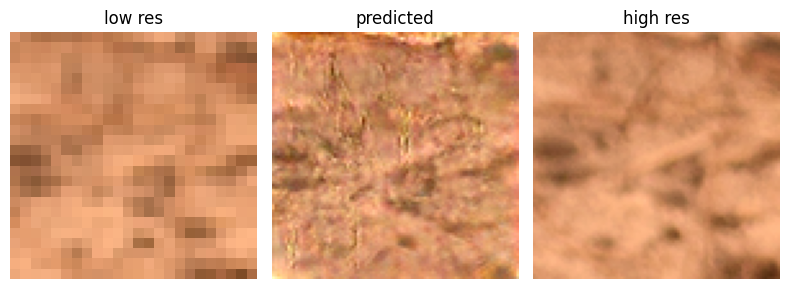

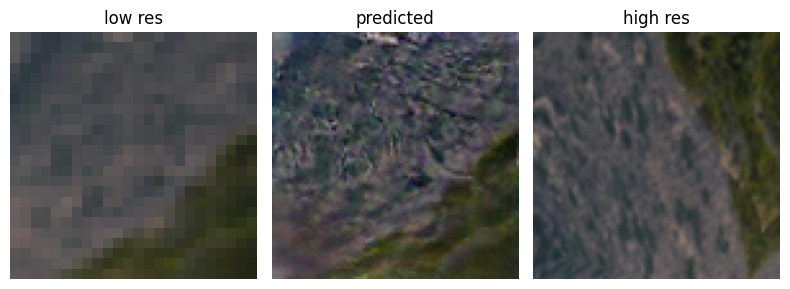

EPOCH: 17.000  Loss_D: 0.318  Loss_G: 0.030  (1441.66s - 1102.45s remaining)
EPOCH: 18.000  Loss_D: 0.348  Loss_G: 0.028  (1524.21s - 1016.14s remaining)
EPOCH: 19.000  Loss_D: 0.408  Loss_G: 0.028  (1605.13s - 929.29s remaining))
EPOCH: 20.000  Loss_D: 0.231  Loss_G: 0.028  (1689.11s - 844.55s remaining)
EPOCH: 20.980  Loss_G: 0.023  Loss_D: 0.263  (1769.80s - 760.90s remaining)

EPOCH: 21.000  Loss_D: 0.262  Loss_G: 0.028  (1771.65s - 759.28s remaining)


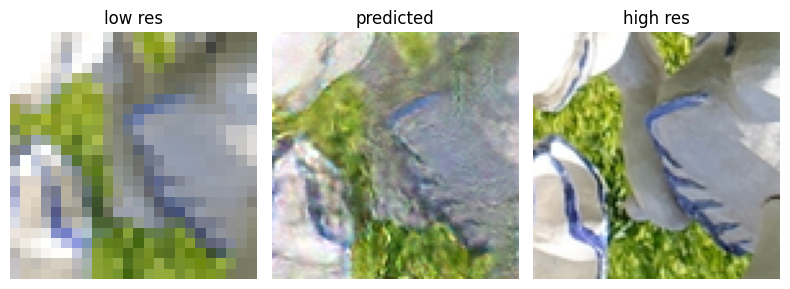

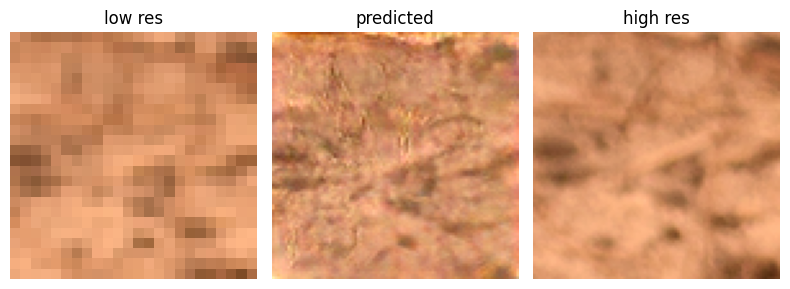

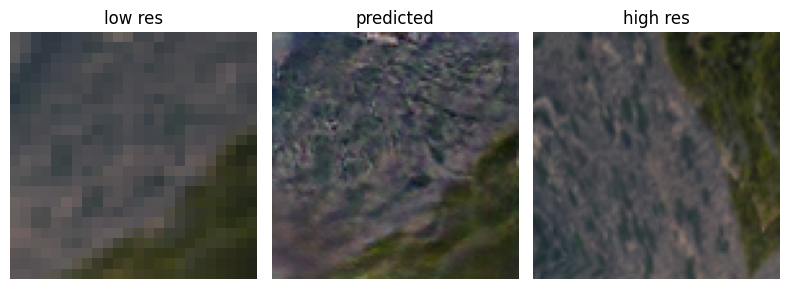

EPOCH: 22.000  Loss_D: 0.305  Loss_G: 0.028  (1855.31s - 674.66s remaining)
EPOCH: 23.000  Loss_D: 0.303  Loss_G: 0.028  (1936.79s - 589.46s remaining)
EPOCH: 24.000  Loss_D: 0.241  Loss_G: 0.028  (2017.89s - 504.47s remaining)
EPOCH: 25.000  Loss_D: 0.259  Loss_G: 0.029  (2100.18s - 420.04s remaining)
EPOCH: 26.000  Loss_D: 0.303  Loss_G: 0.029  (2181.36s - 335.59s remaining)


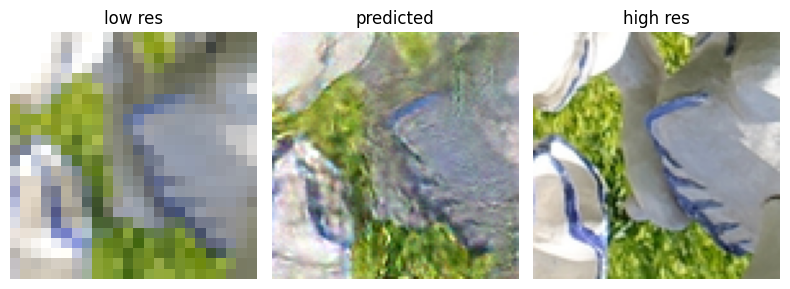

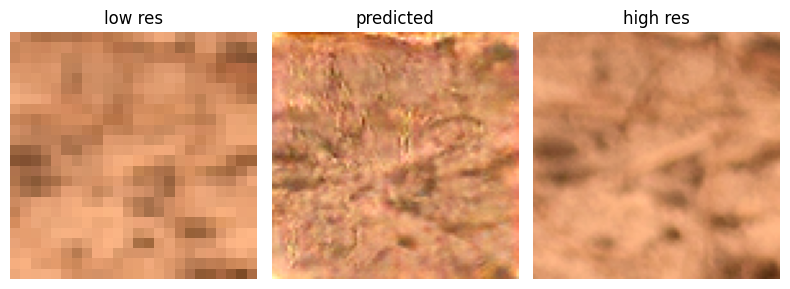

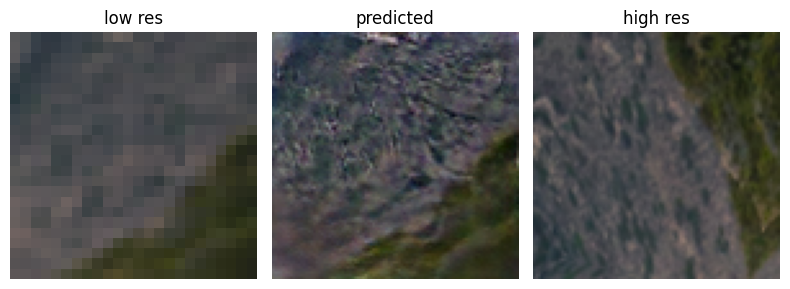

EPOCH: 27.000  Loss_D: 0.400  Loss_G: 0.030  (2265.48s - 251.72s remaining)
EPOCH: 28.000  Loss_D: 0.375  Loss_G: 0.029  (2346.99s - 167.64s remaining)
EPOCH: 29.000  Loss_D: 0.273  Loss_G: 0.028  (2429.81s - 83.79s remaining))
EPOCH: 30.000  Loss_D: 0.294  Loss_G: 0.030  (2511.09s - 0.00s remaining))


In [17]:
epochs = 30
log = Report(epochs)
img_list = []
G_losses = []
D_losses = []
plot_examples(generator, n=3, lr=lr, hr=hr)

for epoch in range(epochs):
    N = len(dataloader)
    for i, (lr_imgs, hr_imgs) in enumerate(dataloader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        valid = torch.ones((lr_imgs.size(0), 1, 6, 6), requires_grad=False).to(device)   
        fake = torch.zeros((lr_imgs.size(0), 1, 6, 6), requires_grad=False).to(device)
        
        # Train the Generator
        optimizer_G.zero_grad()
        generated_images = generator(lr_imgs.to(device))
        pixel_loss = content_loss(generated_images, hr_imgs)
        content_Loss = content_loss(feature_extractor(generated_images), feature_extractor(hr_imgs)) * 0.006
        adversarial_Loss = adversarial_loss(discriminator(generated_images), valid) * 1e-3
        Loss_G = content_Loss + adversarial_Loss + pixel_loss
        Loss_G.backward()
        optimizer_G.step()

        # Train the Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(hr_imgs), valid)
        fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake)

        Loss_D = (real_loss + fake_loss) / 2
        Loss_D.backward()
        optimizer_D.step()
        pos = epoch + (1+i)/N
        log.record(pos, Loss_G=Loss_G.detach(), Loss_D=Loss_D.detach(), end='\r')
        
    # print('='*100)
    # print('pixel_loss: ', pixel_loss.item() ,'content_Loss:', content_Loss.item(), 'adversarial_Loss:', adversarial_Loss.item())
    # print('='*100)
    G_losses.append(Loss_G.item())
    D_losses.append(Loss_D.item())
    log.report_avgs(epoch+1)
    # Save generated images for visualization
    if epoch % 5 == 0:
        plot_examples(generator, n=3, lr=lr, hr=hr)
        print('='*100)
        print('='*100)
        # Ensure images are on CPU and detach
        lr_img, hr_img = next(iter(dataloader))
        lr_img_save = lr_img[:8].cpu().detach()
        hr_img_save = hr_img[:8].cpu().detach()
        generated_img = generator(lr_img_save.to(device)).cpu().detach()
        # Apply the transformation to each image in the batch
        interpolate_transform = InterpolateAndConcatenate(target_size=(96, 96))
        concatenated_images = [interpolate_transform(lr, gen, hr) for lr, hr, gen in zip(lr_img_save, generated_img, hr_img_save)]
        concatenated_images = torch.stack(concatenated_images)
        save_image(concatenated_images.data, f"TrainingPhoto/epoch{epoch}.png")
        # if epoch == 100:
        #     torch.save(generator.state_dict(), 'generator_300epoch.pth')
        #     torch.save(discriminator.state_dict(), 'discriminator_300epoch.pth')
        torch.save(generator.state_dict(), 'generator_430epoch.pth')
        torch.save(discriminator.state_dict(), 'discriminator_430epoch.pth')

save_image(generated_images.data, "TrainingPhoto/final_generated.png")


In [1]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(y=G_losses, mode='lines', name='Generator Loss'))

fig.update_layout(title='Generator Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(y=D_losses, mode='lines', name='Discriminator Loss'))
fig.update_layout(title='Discriminator Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

NameError: name 'G_losses' is not defined